# 4. 데이터 모델링

이번 장에서는 torchvision에서 제공하는 one-stage 모델인 RetinaNet을 활용하여 의료용 마스크 검출 모델을 구축해보겠습니다. torchvision API를 활용하여 사전 훈련된 모델을 가지고 온 후 전이 학습을 통해 모델을 구축할 것입니다. 


In [2]:
!pip install mapcalc

  Created wheel for mapcalc: filename=mapcalc-0.1.1-cp36-none-any.whl size=4358 sha256=d4f8c69bbf1af587595d9ef283bc7be30699c4cdc5ec35fa2b02e0a9bd7bf233
  Stored in directory: /root/.cache/pip/wheels/d4/cf/c7/1d7e3b774fe610e31c0611176fbbbfaead125a3611800caee5
Successfully built mapcalc


In [3]:
import mapcalc

In [37]:
# xmin, xmax, ymin, ymax
true = {'boxes':[[0,100,0,100],
                 [200,250,0,100]],
        'labels':[0, 1]}

pred = {'boxes':[[0,100,0,100],
                 [200,250,0,100]],
        'labels':[0, 1],
        'scores':[0.9, 0.6]}

In [38]:
mapcalc.calculate_map(true, pred, 0.5)

0.5

In [39]:
mapcalc.calculate_map_range(true, pred, 0.05, 0.95, 0.05)

0.5

In [ ]:
from mapcalc import calculate_map, calculate_map_range

# calculates the mAP for an IOU threshold of 0.5
calculate_map(ground_truth, result, 0.5)

# calculates the mAP average for the IOU thresholds 0.05, 0.1, 0.15, ..., 0.90, 0.95.
calculate_map_range(ground_truth, result, 0.05, 0.95, 0.05)

## 4.1 데이터 다운로드

모델링 실습을 위해 2.1절에 나온 코드를 활용하여 데이터를 불러오겠습니다.

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-DataLoader
!python Tutorial-Book-DataLoader/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-DataLoader'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
Face Mask Detection.zip is done!


## 4.2 데이터 분리
3.4절에서 확인한 데이터 분리 방법을 활용하여 데이터를 분리하겠습니다. 

In [ ]:
import os
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

683
683


총 853개의 이미지가 존재하는 것을 볼 수 있습니다. 일반적으로 학습 데이터와 시험 데이터의 비율은 7:3 으로 가져갑니다. 이번 데이터는 전체 데이터셋 개수가 적으므로 8:2 비율을 가져가보도록 하겠습니다. 853개의 데이터 중 170개를 시험 데이터로 사용하기 위해 해당 데이터를 별도의 폴더로 옮겨 주도록 하겠습니다. 우선 리눅스 명령어 mkdir를 활용하여 시험 데이터를 담을 폴더를 생성합니다. 

In [ ]:
!mkdir test_images
!mkdir test_annotations

위 코드를 실행 하면 그림 4.2와 같이 test_images 폴더와 test_annotations 폴더가 생성된 것을 확인할 수 있습니다. 이제 images 폴더와 annotations 폴더에 있는 파일 각각 170개씩을 새로 생성한 폴더로 옮기겠습니다. random 모듈에 있는 sample 함수를 활용해 무작위로 숫자를 추출한 후 인덱스 값으로 활용하겠습니다. 

In [ ]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)



위의 코드 처럼 shutil 패키지를 활용해 170개의 이미지와 170개의 좌표 파일들을 각각 test_images폴더와 test_annotations 폴더로 옮길 수 있습니다. 각 폴더별 파일 개수를 확인하면 아래와 같이 나올 것입니다. 

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


## 4.3 데이터셋 클래스 정의
파이토치 모델을 학습시키기 위해선 데이터셋 클래스를 정의해야 합니다. torchvision에서 제공하는 객체 탐지 모델을 학습시키기 위한 데이터셋 클래스의 `__getitem__` 메서드는 이미지 파일과 바운딩 박스 좌표를 반환해야 합니다. 데이터셋 클래스를 아래 코드를 통해 정의 하겠습니다. (부가 설명 필요, getitems 에 대한 설명 더, pytorch공식문서 참고)

In [ ]:
!git clone https://github.com/Paperspace/DataAugmentationForObjectDetection
import os
os.chdir('DataAugmentationForObjectDetection')
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
os.chdir('../')

In [ ]:
# import numpy as np 
# import pandas as pd 
# from bs4 import BeautifulSoup
# import torchvision
# from torchvision import transforms, datasets, models
# import torch
# from PIL import Image
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
# import os


# def generate_box(obj):
    
#     xmin = int(obj.find('xmin').text)
#     ymin = int(obj.find('ymin').text)
#     xmax = int(obj.find('xmax').text)
#     ymax = int(obj.find('ymax').text)
    
#     return [xmin, ymin, xmax, ymax]

# def generate_label(obj):
#     if obj.find('name').text == "with_mask":
#         return 1
#     elif obj.find('name').text == "mask_weared_incorrect":
#         return 2
#     return 0

# def generate_target(image_id, file): 
#     with open(file) as f:
#         data = f.read()
#         soup = BeautifulSoup(data, 'html.parser')
#         objects = soup.find_all('object')

#         num_objs = len(objects)

       
#         boxes = []
#         labels = []
#         for i in objects:
#             boxes.append(generate_box(i))
#             labels.append(generate_label(i))
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         labels = torch.as_tensor(labels, dtype=torch.int64)
#         # Tensorise img_id
#         img_id = torch.tensor([image_id])
#         # Annotation is in dictionary format
#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["image_id"] = img_id
        
#         return target


# class MaskDataset(object):
#     def __init__(self, transforms, path):
#         '''
#         path: path to train folder or test folder
#         '''
#         # transform module과 img path 경로를 정의
#         self.transforms = transforms
#         # load all image files, sorting them to
#         # ensure that they are aligned
#         self.path = path
#         self.imgs = list(sorted(os.listdir(self.path)))


#     def __getitem__(self, idx): #special method
#         # load images ad masks
#         file_image = self.imgs[idx]
#         file_label = self.imgs[idx][:-3] + 'xml'
#         img_path = os.path.join(self.path, file_image)
        
#         if 'test' in self.path:
#             label_path = os.path.join("test_annotations/", file_label)
#         else:
#             label_path = os.path.join("annotations/", file_label)

#         img = Image.open(img_path).convert("RGB")
#         #Generate Label
#         target = generate_target(idx, label_path)
        
#         if self.transforms is not None:
#             img = self.transforms(img)

#         return img, target

#     def __len__(self): # len() 적용가능케 함, special method
#         return len(self.imgs)
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img_path, annotation):
    
    img = img_path.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        # 이미지 읽어오기, 바운딩 박스 읽어오기
        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        # augmentation 실시
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

data_transform = Sequence([RandomHorizontalFlip(0.5), RandomRotate(180)])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/', transform = data_transform)
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
for im, ta in data_loader:
    print(im, ta)
    break

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]),) ({'boxes': tensor([[358.5566, 225.6981, 399.4153, 252.4607],
        [298.2506, 168.8346, 349.5203, 203.1705],
        [232.8646, 102.2513, 285.9851, 136.1460]]), 'labels': tensor([0, 1, 0])},)


최종적으로 훈련용 데이터를 불러올 data_loader와 시험 데이터를 불러오 test_data_loader를 각각 정의합니다. 

## 4.4 모델 불러오기

torchvision에서는 각종 컴퓨터 비전을 위한 모델을 쉽게 사용할 수는 기능을 제공합니다. 객체 탐지 모델도 쉽게 사용할 수 있는 API를 제공합니다. (설명 부자연 스러움 고쳐야함)

torchvision.models 모듈을 활용하여 RetinaNet 모델을 불러오도록 하겠습니다. RetinaNet은 torchvision 0.8.0 이상에서 제공되므로, 아래 코드를 활용하여 torchvision 버전을 맞춰줍니다.

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.8.1+cu101'

torchvision 버전이 0.8.0 이상임을 확인했으면 아래 코드를 실행하여 RetinaNet 모델을 불러옵니다. Face Mask Detection 데이터셋에 3개의 클래스가 존재하므로 num_classes 매개변수를 3으로 정의하고, 전이 학습을 할 것이기 때문에 backbone 구조는 사전 학습 된 가중치를, 그 외 가중치는 초기화 상태로 가져옵니다.

COCO 데이터셋에 pretrain 된것 설명 추가

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

## 4.5 전이 학습

모델을 불러왔으면 아래 코드를 활용하여 전이 학습을 진행합니다. (코드 셀 나눠서 설명 더 추가해야함)

In [ ]:
#30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 10
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) #loss dict에 뭐가 들어있지?

        losses = sum(loss for loss in loss_dict.values()) #losses에 뭐가 나오지?

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses # losses가 음수인가? 왜 더하기만 하는데 줄어들지?
    print(epoch_loss, f'time: {time.time() - start}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(224.9009, device='cuda:0', grad_fn=<AddBackward0>) time: 254.03568530082703
tensor(191.4562, device='cuda:0', grad_fn=<AddBackward0>) time: 253.98327660560608
tensor(164.8390, device='cuda:0', grad_fn=<AddBackward0>) time: 254.9784061908722
tensor(149.7843, device='cuda:0', grad_fn=<AddBackward0>) time: 254.7991189956665
tensor(130.8039, device='cuda:0', grad_fn=<AddBackward0>) time: 255.5072455406189
tensor(124.4445, device='cuda:0', grad_fn=<AddBackward0>) time: 255.77002906799316
tensor(114.7806, device='cuda:0', grad_fn=<AddBackward0>) time: 255.5262041091919
tensor(109.8518, device='cuda:0', grad_fn=<AddBackward0>) time: 255.75651693344116
tensor(103.2660, device='cuda:0', grad_fn=<AddBackward0>) time: 255.81378293037415
tensor(99.3959, device='cuda:0', grad_fn=<AddBackward0>) time: 255.89959406852722


모델 재사용을 위해 아래 코드를 실행하여 학습된 가중치를 저장해줍니다. 

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

## 4.6 예측

훈련이 마무리 되었으면, 예측 결과를 확인하도록 하겠습니다. 결과 시각화를 위한 각종 함수를 정의해줍니다. 2장 데이터 탐색에서 활용한 함수들을 다시 정의 하겠습니다.

In [ ]:
import matplotlib.image as mpimg
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image(img_path, annotation):
    
    # img = mpimg.imread(img_path)
    img = img_path.cpu().data.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

test_data_loader에서 데이터를 불러와 모델에 넣어 학습 후, 예측된 결과와 실제 값을 각각 시각화 해보도록 하겠습니다.

In [ ]:
for test_img, test_annot in test_data_loader:
    test = list(img.to(device) for img in test_img)
    test_ann = test_annot
    break

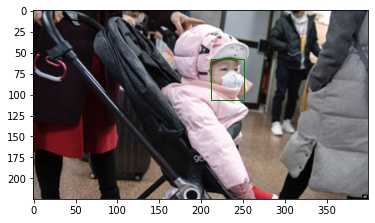

In [ ]:
id = 0
plot_image_from_output(test[id], test_ann[id])

In [ ]:
retina.eval()
preds = retina(test)

In [ ]:
_annot = {'boxes':[preds[id]['boxes'][idx] for idx, score in enumerate(preds[id]['scores']) if score > 0.5],
 'labels':[preds[id]['labels'][idx] for idx, score in enumerate(preds[id]['scores']) if score > 0.5],
 'scores':[preds[id]['scores'][idx] for idx, score in enumerate(preds[id]['scores']) if score > 0.5]}

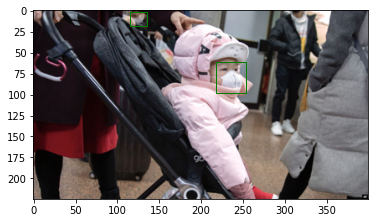

In [ ]:
plot_image_from_output(test[id], _annot)